In [26]:
import pandas as pd
import os
import numpy as np
import hashlib

# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
HOUSING_PATH = "datasets/housing"

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
# view sample housing data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
# view quick description of the data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
# 20640 rows, 10 columns --> ~20k instances
# all categories are numerical, except for ocean proximity (text based)

# inspect 'ocean_proximity'
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
# inspect the rest of the data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


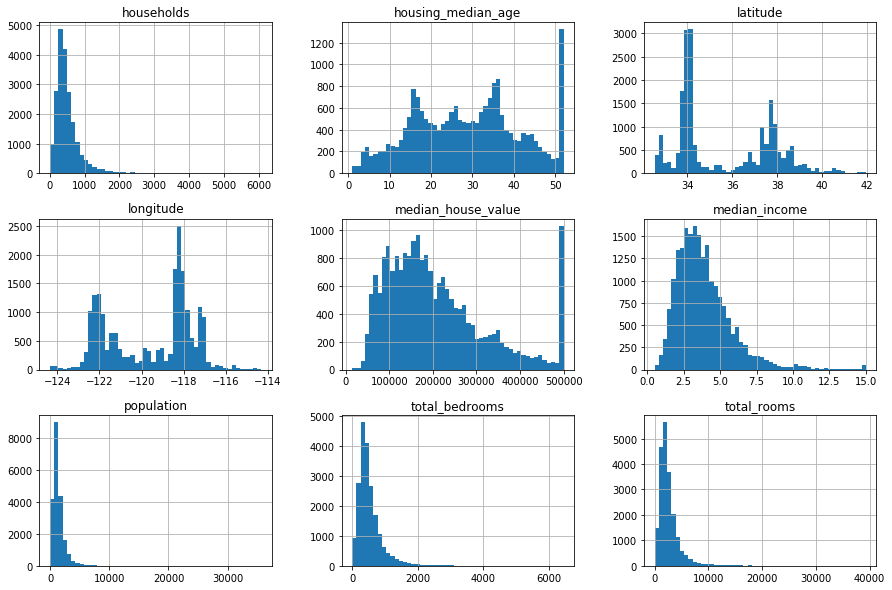

In [19]:
# create histogram of the numerical attributes
housing.hist(bins=50, figsize=(15,10))
plt.show()

## Create Test Set

### Method 1 - with random index

In [21]:
# split data into train|test by passed ratio
def split_train_test(data, test_ratio):
    # shuffled data
    shuffled_indices = np.random.permutation(len(data))
    
    # set partition index(based on ratio) and split
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    # .iloc doc: http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.iloc.html
    return data.iloc[train_indices], data.iloc[test_indices]

In [25]:
# split 80% train, 20 test
train_set, test_set = split_train_test(housing, 0.2)

# ensure it's been split properly
print("{0:6d} Train\n{1:6d} Test".format(len(train_set), len(test_set)))

 16512 Train
  4128 Test


### Method 1 - Problem: 
* What if we add data/dall the function again? 
    * The data will be shuffled in a different way
We could;
1. Seed the random value so it selects the same index
    * but this wouldn't help if we added more data....
2. Set aside the test set and only load the data
    * could work, but how do we manage adding the data?
    
#### Potential solution:
Compute has of instance's identifier, keep last byte, and store values <= `some_value`
_e.g_ for us, if we want 20%, we could keep values <= 51 for test. (51 / 256 = ~20%)

In [34]:
# use hashlib to implement above method
# hashlib documentation: https://docs.python.org/3/library/hashlib.html
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

# rather than use a created index identifier, we'll use long/lat data to create a unique id
housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [35]:
# view sample
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,-122212.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY,-122232.15
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY,-122232.16
